In [1]:
import sys
sys.path.append('/content/drive/MyDrive/importance-sampling')

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10, MNIST, CIFAR100
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
# from torchmetrics.functional import accuracy
import math
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.247, 0.2435, 0.2616],
)

def samplers(n, split_shuffle=True, val_size=0.1):
    if split_shuffle:
        idx = torch.randperm(n, generator=torch.Generator().manual_seed(0))
    else:
        idx = torch.arange(n)
    split_idx = int((1.0 - val_size) * n)
    train_sampler = SubsetRandomSampler(idx[:split_idx])
    val_sampler = SubsetRandomSampler(idx[split_idx:])
    return train_sampler, val_sampler

def train_val_dataloader(root_dir='./cifar10', split_shuffle=True, val_size=0.1, batch_size=120):
    train_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    val_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))


    train_sampler, val_sampler = samplers(len(train_dataset), split_shuffle, val_size)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=int(batch_size / 3))
    return train_dataloader, val_dataloader

def test_dataloader(root_dir='./cifar10', batch_size=120):
    test_dataset = CIFAR10(root=root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    return test_dataloader

In [4]:
def train_batch(model, x_batch, y_batch, loss_fn, optimizer, presample=3.0):
    model.train()
    model.zero_grad()
    batch_size = x_batch.shape[0]
    selected_batch_size = int(batch_size / presample)
    output = model(x_batch)
    num_classes = output.shape[1]
    with torch.no_grad():
        probs = F.softmax(output, dim=1)
        one_hot_targets = F.one_hot(y_batch, num_classes=num_classes)
        g_i_norm = torch.norm(probs - one_hot_targets, dim=-1).detach().cpu().numpy()
    p_i = g_i_norm / np.sum(g_i_norm)
    batch_indices = np.random.choice(np.arange(batch_size), size=selected_batch_size, replace=True, p=p_i)
    selected_p_i = p_i[batch_indices]
    loss = loss_fn(output, y_batch)
    selected_loss = loss[batch_indices]
    w_i = 1.0 / (batch_size * selected_p_i)
    weighted_loss = (torch.tensor(w_i).to(selected_loss.device).detach() * selected_loss).mean()
    weighted_loss.backward()
    optimizer.step()
    batch_loss = loss.mean().cpu().item()
    weighted_batch_loss = weighted_loss.mean().cpu().item()
    max_p_i = np.max(p_i)
    num_unique_points = np.unique(batch_indices).size
    with torch.no_grad():
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()
    return batch_loss, batch_acc_sum, weighted_batch_loss, max_p_i, num_unique_points, selected_batch_size

In [5]:
class VarReductionCondition:

    def __init__(self, vr_th=1.2, momentum=0.9):
        self._vr_th = vr_th
        self._vr = 0.0
        self._previous_vr = 0.0
        self._momentum = momentum

    @property
    def variance_reduction(self):
        return self._vr

    @property
    def satisfied(self):
        self._previous_vr = self._vr
        return self._vr > self._vr_th

    @property
    def previously_satisfied(self):
        return self._previous_vr > self._vr_th
    
    @property
    def string(self):
        return f"vr={self._vr:.3f},  vr_th={self._vr_th:.3f}"

    def update(self, scores):
        u = 1.0/len(scores)
        S = scores.sum()
        if S == 0:
            g = np.array(u)
        else:
            g = scores/S
        new_vr = 1.0 / np.sqrt(1 - ((g-u)**2).sum()/(g**2).sum())
        self._vr = (
            self._momentum * self._vr +
            (1-self._momentum) * new_vr
        )


def get_g(output, y_batch  ):
    num_classes = output.shape[1]
    with torch.no_grad():
        probs = F.softmax(output, dim=1)
        one_hot_targets = F.one_hot(y_batch, num_classes=num_classes)
        g_i_norm = torch.norm(probs - one_hot_targets, dim=-1).detach().cpu().numpy()
    return g_i_norm


def train_batch_is(model,
                x_batch, 
                y_batch, 
                loss_fn, 
                optimizer, 
                condition :VarReductionCondition, 
                presample = 3.0 ):

    flag = False
    model.train()
    model.zero_grad()

    batch_size = x_batch.shape[0]

    selected_batch_size = int(batch_size / presample)
    
    if condition.satisfied :
        #print("condition satisfied")
        output = model(x_batch)
        g_i_norm = get_g(output, y_batch  )
        condition.update(g_i_norm)

    else:
        #print("condition not satisfied")
        g_i_norm = np.ones(batch_size)


    p_i = g_i_norm / np.sum(g_i_norm)
    batch_indices = np.random.choice(np.arange(batch_size), size = selected_batch_size, replace=True, p=p_i)

    selected_p_i = p_i[batch_indices]

    if condition.previously_satisfied:
        loss = loss_fn(output, y_batch)
        selected_loss = loss[batch_indices]
    else :
        output = model(x_batch[batch_indices])
        y_batch = y_batch[batch_indices]
        condition.update( get_g(output, y_batch ) )
        loss = loss_fn(output, y_batch)
        selected_loss = loss
        flag = True

        
    w_i = 1.0 / (batch_size * selected_p_i)

    weighted_loss = (torch.tensor(w_i).to(selected_loss.device).detach() * selected_loss).mean()

    weighted_loss.backward()

    optimizer.step()

    batch_loss = loss.mean().cpu().item()
    weighted_batch_loss = weighted_loss.mean().cpu().item()
    max_p_i = np.max(p_i)

    num_unique_points = np.unique(batch_indices).size

    with torch.no_grad():
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()
    
    #print(len(output), output.shape, batch_acc_sum/len(output),batch_loss)

    return batch_loss, batch_acc_sum, weighted_batch_loss, max_p_i, num_unique_points, selected_batch_size, len(output), flag

In [6]:
def train_epoch(model, dataloader, loss_fn, optimizer, condition: VarReductionCondition, presample = 3):
    epoch_loss = 0.0
    epoch_acc = 0
    epoch_weighted_loss = 0.0
    epoch_max_p_i_s = []
    epoch_num_unique_points_s = []
    epoch_size = 0
    epoch_weighted_size = 0
    epoch_num_of_uniform_samp = 0
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        #batch_loss, batch_acc_sum, weighted_batch_loss, max_p_i, num_unique_points, selected_batch_size = train_batch(model, X_batch.to(model.device), y_batch.to(model.device), loss_fn, optimizer)
        (   batch_loss, 
            batch_acc_sum, 
            weighted_batch_loss, 
            max_p_i, 
            num_unique_points, 
            selected_batch_size,
            incr,
            flag ) = train_batch_is(model, 
                                    X_batch.to(model.device), 
                                    y_batch.to(model.device), 
                                    loss_fn, 
                                    optimizer, 
                                    condition,
                                    presample)
        
        epoch_size += incr #len(X_batch)
        epoch_weighted_size += selected_batch_size
        epoch_loss += batch_loss * incr
        epoch_acc += batch_acc_sum
        epoch_weighted_loss += weighted_batch_loss * selected_batch_size
        epoch_max_p_i_s.append(max_p_i)
        epoch_num_unique_points_s.append(num_unique_points)
        epoch_num_of_uniform_samp += flag
    
    epoch_loss /= epoch_size
    epoch_acc /= epoch_size
    epoch_weighted_loss /= epoch_weighted_size
    return epoch_loss, epoch_acc, epoch_weighted_loss, epoch_max_p_i_s, epoch_num_unique_points_s, epoch_num_of_uniform_samp


In [7]:
def train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, callback=None, presample=2, tau_th = None):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)

    large_batch = int( train_dataloader.batch_size)

    # Compute the threshold using eq. 29 in
    # https://arxiv.org/abs/1803.00942

    B = large_batch
    b = int( large_batch / presample)
    tau_th = float(B + 3*b) / (3*b) if tau_th is None else   tau_th

    condition = VarReductionCondition(tau_th)
    print(condition.string)
    for i_epoch in epochs:
        epoch_loss, epoch_acc, epoch_weighted_loss, epoch_max_p_i_s, epoch_num_unique_points_s, n_un = train_epoch(model, train_dataloader, loss_fn, optimizer, condition, presample)
        print(condition.string + f" n_un={n_un}")
        if callback is not None:
            cb_dict = callback(model, val_dataloader, loss_fn, epoch_loss, epoch_acc, epoch_weighted_loss, epoch_max_p_i_s, epoch_num_unique_points_s, n_un)
            epochs.set_postfix(cb_dict)
            



In [8]:
class CallBack:
    def __init__(self, eval_fn, name=None):
        self.eval_fn = eval_fn
        self.train_losses = []
        self.train_accs = []
        self.train_w_losses = []
        self.train_max_p_i = []
        self.train_num_unique_points = []
        self.val_losses = []
        self.val_accs = []
        self.n_un = []

    def last_info(self):
        return {'loss_train': f'{self.train_losses[-1]:.3f}',
                'acc_train': f'{self.train_accs[-1]:.3f}',
                'w_loss_train': f'{self.train_w_losses[-1]:.3f}',
                'loss_val': f'{self.val_losses[-1]:.3f}',
                'acc_val': f'{self.val_accs[-1]:.3f}',
                'n_un': f'{self.n_un[-1]:.3f}',
        }
    def __call__(self, model, val_dataloader, loss_fn,
                 epoch_loss=None, epoch_acc=None, epoch_weighted_loss=None, epoch_max_p_i_s=None, epoch_num_unique_points_s=None, n_un=None):
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)
        self.train_w_losses.append(epoch_weighted_loss)
        self.train_max_p_i.append(epoch_max_p_i_s)
        self.train_num_unique_points.append(epoch_num_unique_points_s)
        loss_val, acc_val = self.eval_fn(model, val_dataloader, loss_fn)
        self.val_losses.append(loss_val)
        self.val_accs.append(acc_val)
        self.n_un.append(n_un)
        return self.last_info()


In [9]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).mean().item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc



In [10]:
####ResNet
#class BasicBlock(nn.Module):
#    expansion = 1

#    def __init__(self, in_planes, planes, stride=1):
#        super(BasicBlock, self).__init__()
#        self.activation = F.relu
#        self.conv1 = nn.Conv2d(
#            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#        self.bn1 = nn.BatchNorm2d(planes)
#        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
#                               stride=1, padding=1, bias=False)
#        self.bn2 = nn.BatchNorm2d(planes)

#        self.shortcut = nn.Sequential()
#        if stride != 1 or in_planes != self.expansion*planes:
#            self.shortcut = nn.Sequential(
#                nn.Conv2d(in_planes, self.expansion*planes,
#                          kernel_size=1, stride=stride, bias=False),
#                nn.BatchNorm2d(self.expansion*planes)
#            )

#    def forward(self, x):
#        out = self.activation(self.bn1(self.conv1(x)))
#        out = self.bn2(self.conv2(out))
#        out += self.shortcut(x)
#        out = self.activation(out)
#        return out


#class Bottleneck(nn.Module):
#    expansion = 4

#    def __init__(self, in_planes, planes, stride=1):
#        super(Bottleneck, self).__init__()
#        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#        self.bn1 = nn.BatchNorm2d(planes)
#        self.conv2 = nn.Conv2d(
#            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
#        )
#        self.bn2 = nn.BatchNorm2d(planes)
#        self.conv3 = nn.Conv2d(
#            planes, self.expansion * planes, kernel_size=1, bias=False
#        )
#        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

#        self.shortcut = nn.Sequential()
#        if stride != 1 or in_planes != self.expansion * planes:
#            self.shortcut = nn.Sequential(
#                nn.Conv2d(
#                    in_planes,
#                    self.expansion * planes,
#                    kernel_size=1,
#                    stride=stride,
#                    bias=False,
#                ),
#                nn.BatchNorm2d(self.expansion * planes),
#            )

#    def forward(self, x):
#        out = F.relu(self.bn1(self.conv1(x)))
#        out = F.relu(self.bn2(self.conv2(out)))
#        out = self.bn3(self.conv3(out))
#        out += self.shortcut(x)
#        out = F.relu(out)
#        return out

In [11]:
#class ResNet(nn.Module):
#    def __init__(self, block, num_blocks, num_classes=10):
#        super(ResNet, self).__init__()
#        self.in_planes = 64
#        self.activation = F.relu
#        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
#                               stride=1, padding=1, bias=False)
#        self.bn1 = nn.BatchNorm2d(64)
#        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#        self.linear = nn.Linear(512*block.expansion, num_classes)


#    def _make_layer(self, block, planes, num_blocks, stride):
#        strides = [stride] + [1]*(num_blocks-1)
#        layers = []
#        for stride in strides:
#            layers.append(block(self.in_planes, planes, self.activation, stride))
#            self.in_planes = planes * block.expansion
#        return nn.Sequential(*layers)

#    def forward(self, x):
#        out = self.activation(self.bn1(self.conv1(x)))
#        out = self.layer1(out)
#        out = self.layer2(out)
#        out = self.layer3(out)
#        out = self.layer4(out)
#        out = F.avg_pool2d(out, 4)
#        out = out.view(out.size(0), -1)
#        out = self.linear(out)
#        return out


In [12]:
#def ResNet18():
#    return ResNet(BasicBlock, [2, 2, 2, 2])


#def ResNet34():
#    return ResNet(BasicBlock, [3, 4, 6, 3])


#def ResNet50():
#    return ResNet(Bottleneck, [3, 4, 6, 3])

In [13]:
#######
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])



In [14]:
### WideResNet

class BasicBlockW(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0):
        super(BasicBlockW, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))

        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    @staticmethod
    def _make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth=28, num_classes=10, widen_factor=10, drop_rate=0.0):
        super(WideResNet, self).__init__()
        n_channels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = BasicBlockW

        self.conv1 = nn.Conv2d(3, n_channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)

        self.block1 = NetworkBlock(n, n_channels[0], n_channels[1], block, 1, drop_rate)

        self.block2 = NetworkBlock(n, n_channels[1], n_channels[2], block, 2, drop_rate)

        self.block3 = NetworkBlock(n, n_channels[2], n_channels[3], block, 2, drop_rate)

        self.bn1 = nn.BatchNorm2d(n_channels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(n_channels[3], num_classes)
        self.nChannels = n_channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)


In [15]:

train_dataloader, val_dataloader = train_val_dataloader()
test_loader = test_dataloader(batch_size=128*3)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
#device = torch.device( 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ResNet50()
model.to(device)
model.device = device
loss_fn = nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

cb = CallBack(evaluate)
train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=60, callback=cb, presample=3, tau_th = None)

cuda


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

vr=0.000,  vr_th=2.000
vr=1.041,  vr_th=2.000 n_un=0


Epochs:   2%|▏         | 1/60 [01:06<1:05:52, 66.99s/it, loss_train=1.854, acc_train=0.339, w_loss_train=1.854, loss_val=1.673, acc_val=0.417, n_un=0.000]

vr=1.093,  vr_th=2.000 n_un=0


Epochs:   3%|▎         | 2/60 [02:13<1:04:37, 66.85s/it, loss_train=1.481, acc_train=0.456, w_loss_train=1.481, loss_val=1.397, acc_val=0.495, n_un=0.000]

vr=1.133,  vr_th=2.000 n_un=0


Epochs:   5%|▌         | 3/60 [03:20<1:03:21, 66.69s/it, loss_train=1.271, acc_train=0.543, w_loss_train=1.271, loss_val=1.285, acc_val=0.550, n_un=0.000]

vr=1.177,  vr_th=2.000 n_un=0


Epochs:   7%|▋         | 4/60 [04:27<1:02:26, 66.91s/it, loss_train=1.128, acc_train=0.594, w_loss_train=1.128, loss_val=1.115, acc_val=0.604, n_un=0.000]

vr=1.216,  vr_th=2.000 n_un=0


Epochs:   8%|▊         | 5/60 [05:34<1:01:13, 66.78s/it, loss_train=1.055, acc_train=0.621, w_loss_train=1.055, loss_val=1.292, acc_val=0.581, n_un=0.000]

vr=1.233,  vr_th=2.000 n_un=0


Epochs:  10%|█         | 6/60 [06:41<1:00:19, 67.03s/it, loss_train=0.968, acc_train=0.661, w_loss_train=0.968, loss_val=0.961, acc_val=0.662, n_un=0.000]

vr=1.290,  vr_th=2.000 n_un=0


Epochs:  12%|█▏        | 7/60 [07:49<59:22, 67.22s/it, loss_train=0.892, acc_train=0.686, w_loss_train=0.892, loss_val=1.007, acc_val=0.654, n_un=0.000]  

vr=1.291,  vr_th=2.000 n_un=0


Epochs:  13%|█▎        | 8/60 [08:55<58:06, 67.05s/it, loss_train=0.837, acc_train=0.709, w_loss_train=0.837, loss_val=1.008, acc_val=0.669, n_un=0.000]

vr=1.334,  vr_th=2.000 n_un=0


Epochs:  15%|█▌        | 9/60 [10:02<56:55, 66.97s/it, loss_train=0.772, acc_train=0.728, w_loss_train=0.772, loss_val=0.801, acc_val=0.721, n_un=0.000]

vr=1.371,  vr_th=2.000 n_un=0


Epochs:  17%|█▋        | 10/60 [11:09<55:52, 67.05s/it, loss_train=0.720, acc_train=0.752, w_loss_train=0.720, loss_val=1.051, acc_val=0.645, n_un=0.000]

vr=1.431,  vr_th=2.000 n_un=0


Epochs:  18%|█▊        | 11/60 [12:17<54:53, 67.21s/it, loss_train=0.682, acc_train=0.761, w_loss_train=0.682, loss_val=0.800, acc_val=0.723, n_un=0.000]

vr=1.530,  vr_th=2.000 n_un=0


Epochs:  20%|██        | 12/60 [13:25<53:55, 67.42s/it, loss_train=0.627, acc_train=0.781, w_loss_train=0.627, loss_val=0.749, acc_val=0.739, n_un=0.000]

vr=1.520,  vr_th=2.000 n_un=0


Epochs:  22%|██▏       | 13/60 [14:33<52:53, 67.51s/it, loss_train=0.608, acc_train=0.795, w_loss_train=0.608, loss_val=0.781, acc_val=0.743, n_un=0.000]

vr=1.553,  vr_th=2.000 n_un=0


Epochs:  23%|██▎       | 14/60 [15:41<51:53, 67.69s/it, loss_train=0.551, acc_train=0.810, w_loss_train=0.551, loss_val=0.688, acc_val=0.766, n_un=0.000]

vr=1.548,  vr_th=2.000 n_un=0


Epochs:  25%|██▌       | 15/60 [16:49<50:51, 67.82s/it, loss_train=0.554, acc_train=0.810, w_loss_train=0.554, loss_val=0.676, acc_val=0.772, n_un=0.000]

vr=1.590,  vr_th=2.000 n_un=0


Epochs:  27%|██▋       | 16/60 [17:56<49:40, 67.73s/it, loss_train=0.494, acc_train=0.834, w_loss_train=0.494, loss_val=0.621, acc_val=0.790, n_un=0.000]

vr=1.685,  vr_th=2.000 n_un=0


Epochs:  28%|██▊       | 17/60 [19:05<48:39, 67.91s/it, loss_train=0.486, acc_train=0.830, w_loss_train=0.486, loss_val=0.769, acc_val=0.748, n_un=0.000]

vr=1.626,  vr_th=2.000 n_un=0


Epochs:  30%|███       | 18/60 [20:13<47:35, 67.98s/it, loss_train=0.444, acc_train=0.846, w_loss_train=0.444, loss_val=0.629, acc_val=0.789, n_un=0.000]

vr=1.732,  vr_th=2.000 n_un=0


Epochs:  32%|███▏      | 19/60 [21:21<46:27, 67.99s/it, loss_train=0.433, acc_train=0.849, w_loss_train=0.433, loss_val=0.817, acc_val=0.772, n_un=0.000]

vr=1.717,  vr_th=2.000 n_un=0


Epochs:  33%|███▎      | 20/60 [22:29<45:20, 68.01s/it, loss_train=0.402, acc_train=0.863, w_loss_train=0.402, loss_val=0.621, acc_val=0.791, n_un=0.000]

vr=1.725,  vr_th=2.000 n_un=0


Epochs:  35%|███▌      | 21/60 [23:36<43:56, 67.60s/it, loss_train=0.392, acc_train=0.868, w_loss_train=0.392, loss_val=0.761, acc_val=0.777, n_un=0.000]

vr=1.880,  vr_th=2.000 n_un=0


Epochs:  37%|███▋      | 22/60 [24:43<42:52, 67.69s/it, loss_train=0.353, acc_train=0.880, w_loss_train=0.353, loss_val=0.612, acc_val=0.808, n_un=0.000]

vr=1.892,  vr_th=2.000 n_un=0


Epochs:  38%|███▊      | 23/60 [25:50<41:32, 67.36s/it, loss_train=0.363, acc_train=0.879, w_loss_train=0.363, loss_val=0.585, acc_val=0.808, n_un=0.000]

vr=2.495,  vr_th=2.000 n_un=0


Epochs:  40%|████      | 24/60 [28:12<53:46, 89.63s/it, loss_train=0.204, acc_train=0.932, w_loss_train=0.212, loss_val=0.500, acc_val=0.846, n_un=0.000]

vr=2.696,  vr_th=2.000 n_un=0


Epochs:  42%|████▏     | 25/60 [30:41<1:02:41, 107.47s/it, loss_train=0.127, acc_train=0.956, w_loss_train=0.127, loss_val=0.525, acc_val=0.852, n_un=0.000]

vr=3.011,  vr_th=2.000 n_un=0


Epochs:  43%|████▎     | 26/60 [33:10<1:08:00, 120.02s/it, loss_train=0.087, acc_train=0.971, w_loss_train=0.087, loss_val=0.552, acc_val=0.852, n_un=0.000]

vr=3.202,  vr_th=2.000 n_un=0


Epochs:  45%|████▌     | 27/60 [35:39<1:10:49, 128.77s/it, loss_train=0.066, acc_train=0.978, w_loss_train=0.066, loss_val=0.644, acc_val=0.842, n_un=0.000]

vr=3.282,  vr_th=2.000 n_un=0


Epochs:  47%|████▋     | 28/60 [38:09<1:11:59, 135.00s/it, loss_train=0.061, acc_train=0.979, w_loss_train=0.062, loss_val=0.683, acc_val=0.838, n_un=0.000]

vr=3.180,  vr_th=2.000 n_un=0


Epochs:  48%|████▊     | 29/60 [40:44<43:33, 84.31s/it, loss_train=0.068, acc_train=0.977, w_loss_train=0.068, loss_val=0.671, acc_val=0.833, n_un=0.000]   


KeyboardInterrupt: 

In [59]:
loss, acc = evaluate(model, test_loader, loss_fn)
print(f'ResNet50, test loss: {loss}')
print(f'ResNet50, test accuracy: {acc}')

ResNet50, test loss: 0.8214460015296936
ResNet50, test accuracy: 0.7186


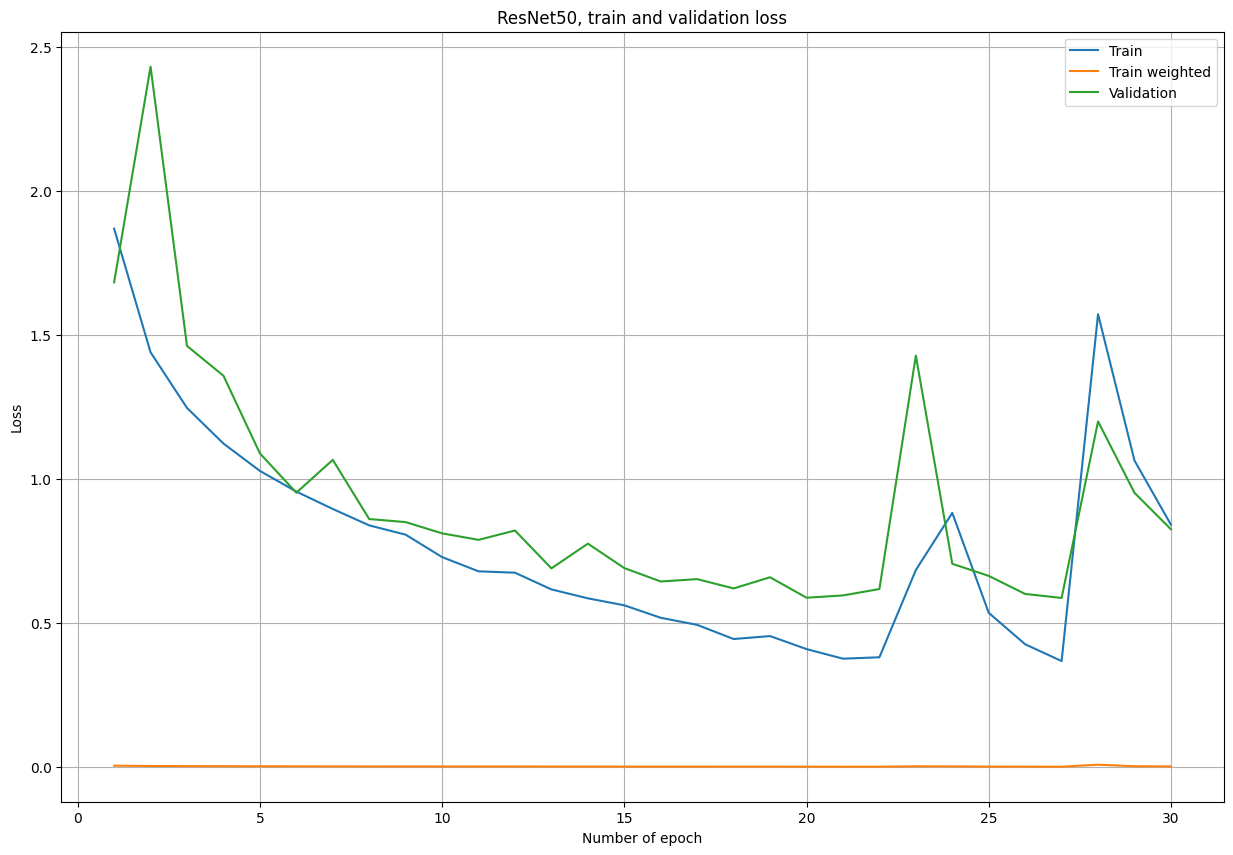

In [60]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_losses, label='Train')
plt.plot(epochs, cb.train_w_losses, label='Train weighted')
plt.plot(epochs, cb.val_losses, label='Validation')
plt.legend()
plt.grid(True)


In [ ]:
print(f'Best loss on train: {np.min(cb.train_losses)}, on {np.argmin(cb.train_losses) + 1} epoch')
print(f'Best weighted loss on train: {np.min(cb.train_w_losses)}, on {np.argmin(cb.train_w_losses) + 1} epoch')
print(f'Best loss on validation: {np.min(cb.val_losses)}, on {np.argmin(cb.val_losses) + 1} epoch')

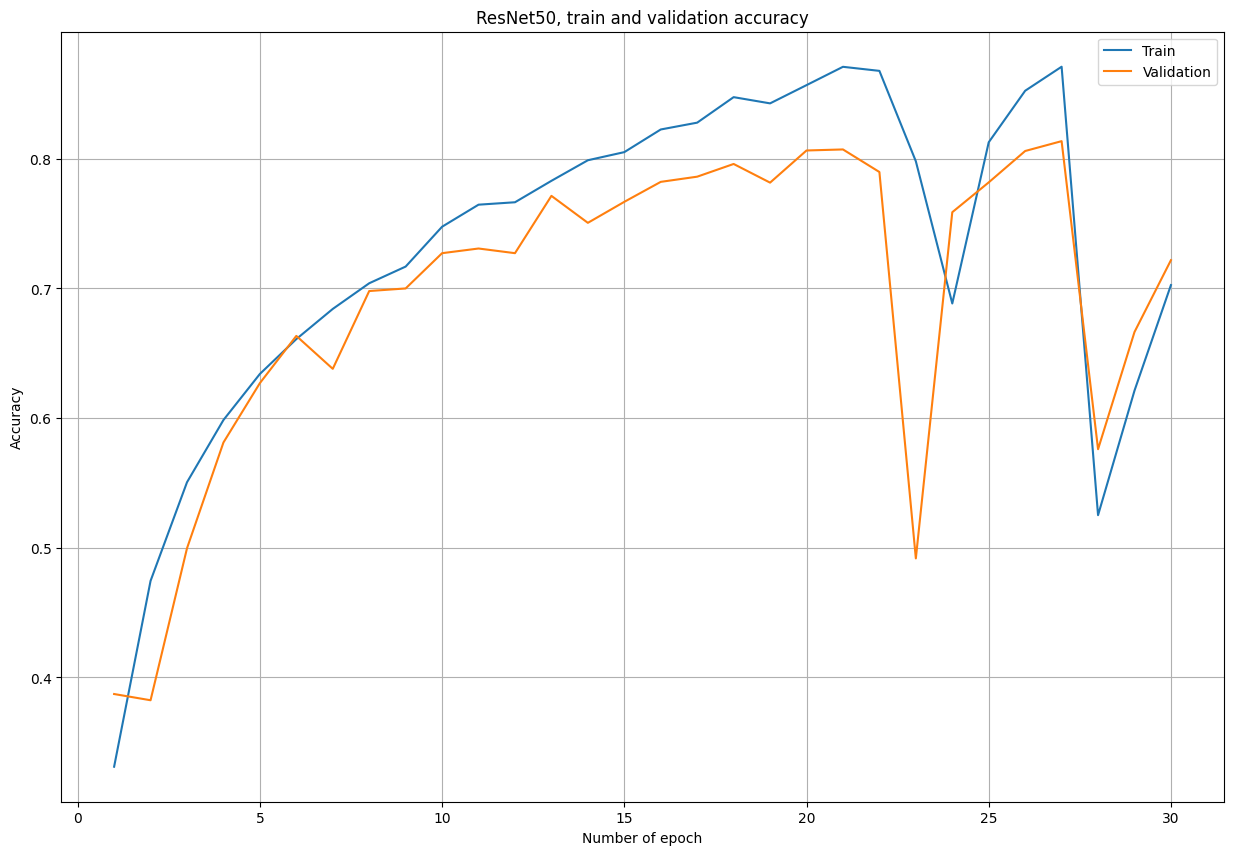

In [61]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, train and validation accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
epochs = np.arange(30) + 1
plt.plot(epochs, cb.train_accs, label='Train')
plt.plot(epochs, cb.val_accs, label='Validation')
plt.legend()
plt.grid(True)

In [ ]:
print(f'Best accuracy on train: {np.max(cb.train_accs)}, on {np.argmax(cb.train_accs) + 1} epoch')
print(f'Best accuracy on validation: {np.max(cb.val_accs)}, on {np.argmax(cb.val_accs) + 1} epoch')